In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer

# Data base import

In [2]:
from utils import sample_data

# -- Get the data -- #
NB_SAMPLES = 1000
TRAIN_SAMPLE = Path("../data/samples/sample_{}_train.csv".format(NB_SAMPLES))
VALID_SAMPLE = Path("../data/samples/sample_{}_validation.csv".format(NB_SAMPLES))
TRAIN_SAMPLE = pd.read_csv(TRAIN_SAMPLE).to_numpy()
VALID_SAMPLE = pd.read_csv(VALID_SAMPLE).to_numpy()


# -- Clean the data -- #
from utils.clean_data import clean_data
TRAIN_SAMPLE = clean_data(TRAIN_SAMPLE)
VALID_SAMPLE = clean_data(VALID_SAMPLE)

In [3]:
print(TRAIN_SAMPLE)

[['8fc8d9bd09' 'i feel really weird' 'weird' -1]
 ['7eea1e9cdf' 'Too many cocktails last night, my head hurts' 'hurts' -1]
 ['398128d145'
  'twice in a week Qantas club lounge computers broken  #flyertalk'
  'twice in a week Qantas club lounge computers broken  #flyertalk' 0]
 ...
 ['24ff960250' ' artery tomorrow. No more Hagen Daz for me'
  'artery tomorrow. No more Hagen Daz for me' 0]
 ['35b5a783cf'
  ' Here are some that other tweeple recommend to me: www.audiomicro.com , http://tr.im/gWOy , http://tr.im/gWPx'
  'Here are some that other tweeple recommend to me: www.audiomicro.com , http://tr.im/gWOy , http://tr.im/gWPx'
  0]
 ['1d1a84678c'
  'Getting ready to go to #Brighton to find myself a new suit from #GreshamBlake - Sunday = me time'
  'Getting ready to go to #Brighton to find myself a new suit from #GreshamBlake - Sunday = me time'
  0]]


# Pre-processing
#### TWEET_ORIGINALS : List of the tweets : Array, shape = (len(nb_tweets))
#### TWEET_STRINGS : List of the list of the word of each tweet : List of list of string
#### TWEET_SCALARS : List of the description of each tweet : Array, shape = (len(nb_tweets), sentence_size * word_size)
#### IMPORTANT_WORDS : List of the label of each tweet : Array, shape = (len(nb_tweets), sentence_size)

In [4]:
# -- Parameters -- #
WORD_SIZE = 50  # 50 or 100 or 200 or 300
FILL_WITH = 0  # If a word is not in the dictionary, [0, ..., 0] will describe it.
SENTIMENT_WEIGHT = 1  # Multiply the sentiment by a factor
SENTENCE_SIZE = 50  # What ever
OPTIONS = [WORD_SIZE, SENTENCE_SIZE, FILL_WITH, SENTIMENT_WEIGHT]


# -- Get the original tweets -- #
TWEET_ORIGINALS_TRAIN = TRAIN_SAMPLE[:, 1]
TWEET_ORIGINALS_VALID = VALID_SAMPLE[:, 1]
print("First tweet :")
print(TWEET_ORIGINALS_TRAIN[0])
print("Shape of TWEET_ORIGINAL :", TWEET_ORIGINALS_TRAIN.shape)

First tweet :
i feel really weird
Shape of TWEET_ORIGINAL : (966,)


In [6]:
from descriptors.tweet_string.create_strings import create_strings
from descriptors.tokenizer.tokenizer import Tokenizer

# Initialize the tokenizer
TOKENIZER = Tokenizer()

# -- Get the decomposition of the tweets -- #
TWEET_STRINGS_TRAIN = create_strings(TWEET_ORIGINALS_TRAIN, TOKENIZER, SENTENCE_SIZE)
TWEET_STRINGS_VALID = create_strings(TWEET_ORIGINALS_VALID, TOKENIZER, SENTENCE_SIZE)
print("Decomposition of the first tweet :")
print(TWEET_STRINGS_TRAIN[0])
print("Length of TWEET_STRING :", len(TWEET_STRINGS_TRAIN))

Decomposition of the first tweet :
['i', 'feel', 'really', 'weird']
Length of TWEET_STRING : 966


In [7]:
from descriptors.descriptor_glove.descriptor_glove import tweet_scalar_glove
from utils.standardize import standardize


# Get the dictionary
PATH_DICTIONARY = Path("../data/glove_descriptor/glove.6B.{}d.txt".format(WORD_SIZE))
# PATH_DICTIONARY = Path("../data/glove_descriptor/sample_test.txt")
DICTIONARY = pd.read_csv(PATH_DICTIONARY, sep=" ", header=None)

# Additional dictionary
ADDITIONAL_DIC = {"..": "...", "<3": "love"}

# Get the sentiments
SENTIMENTS_TRAIN = TRAIN_SAMPLE[:, -1]
SENTIMENTS_VALID = VALID_SAMPLE[:, -1]

# -- Get the decriptions of each tweets -- #
TWEET_SCALARS_TRAIN = tweet_scalar_glove(TWEET_STRINGS_TRAIN, SENTIMENTS_TRAIN, DICTIONARY, ADDITIONAL_DIC, OPTIONS)
TWEET_SCALARS_VALID = tweet_scalar_glove(TWEET_STRINGS_VALID, SENTIMENTS_VALID, DICTIONARY, ADDITIONAL_DIC, OPTIONS)

# Standardize the tweet descriptions
standardize(TWEET_SCALARS_TRAIN)
standardize(TWEET_SCALARS_VALID)

print("Description of the first tweet :")
print(TWEET_SCALARS_TRAIN[0])
print("Shape of TWEET_SCLALAR :", TWEET_SCALARS_TRAIN.shape)
print(TWEET_SCALARS_VALID.shape)

Description of the first tweet :
[ 0.13417587 -0.02395894 -0.21725474 ... -0.03219114 -0.03219114
 -1.        ]
Shape of TWEET_SCLALAR : (966, 2501)
(966, 2501)


In [8]:
from descriptors.tweet_label.create_labels import create_labels

# Create the decompositions of the labels
LABEL_ORIGINALS_TRAIN = TRAIN_SAMPLE[:, 2]
LABEL_ORIGINALS_VALID = VALID_SAMPLE[:, 2]
LABEL_STRINGS_TRAIN = create_strings(LABEL_ORIGINALS_TRAIN, TOKENIZER, SENTENCE_SIZE)
LABEL_STRINGS_VALID = create_strings(LABEL_ORIGINALS_VALID, TOKENIZER, SENTENCE_SIZE)

# -- Get the labels -- #
IMPORTANT_WORDS_TRAIN = create_labels(TWEET_STRINGS_TRAIN, LABEL_STRINGS_TRAIN, SENTENCE_SIZE)

IDX = 5
print(TWEET_ORIGINALS_TRAIN[IDX])
print(LABEL_ORIGINALS_TRAIN[IDX])
print("Labels :")
print(IMPORTANT_WORDS_TRAIN[IDX])
print("Shape of IMPORTANT_WORDS :", IMPORTANT_WORDS_TRAIN.shape)

 Can I have a splodge of ketchup on mine please?!
Can I have a splodge of ketchup on mine please?!
Labels :
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Shape of IMPORTANT_WORDS : (966, 50)


# Classification

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from utils.post_processing import preds_to_strings
from utils.loss import mean_jaccard

#### All the sentiments in the same Classifier

In [58]:
# --- Optimize the number of neighbors and the weight sentiment --- #
# Parameter
NB_NEIGHBORS_MAX = 400
NB_NEIGHBORS_MIN = 20
STEP_NEIGH = 40
SENTIMENT_WEIGHT_MAX = 200
SENTIMENT_WEIGHT_MIN = 1
STEP_WEIGHT = 15

# Variables
NB_NEIGHBORS_OPT = 1
SENTIMENT_WEIGHT_OPT = 1
JACCARD_ACC_MAX = 0
JACCARD_LIST = []

for nb_neigh in range(NB_NEIGHBORS_MIN, NB_NEIGHBORS_MAX, STEP_NEIGH):
    for sentiment_weight in range(SENTIMENT_WEIGHT_MIN, SENTIMENT_WEIGHT_MAX, STEP_WEIGHT):
        # Modify the sentiments
        SCALARS_TRAIN = TWEET_SCALARS_TRAIN.copy()
        SCALARS_TRAIN[:, -1] *= sentiment_weight
        SCALARS_VALID = TWEET_SCALARS_VALID.copy()
        SCALARS_VALID[:, -1] *= sentiment_weight
        
        # Define the knn
        KNN = KNeighborsRegressor(nb_neigh, weights="distance")

        # Train the knn
        KNN.fit(SCALARS_TRAIN, IMPORTANT_WORDS_TRAIN)

        # Scalar predictions
        PRED_SCALAR = KNN.predict(SCALARS_VALID)

        # Get the string predictions
        PRED_STRING = preds_to_strings(TWEET_ORIGINALS_VALID, TWEET_STRINGS_VALID, PRED_SCALAR)

        # Compute the loss
        JACCARD_ACC = mean_jaccard(LABEL_ORIGINALS_VALID, PRED_STRING)

        # Print results
        print("Jaccard score", JACCARD_ACC)
        print("Sentiment weight", sentiment_weight)
        print("Number neighbors", nb_neigh)
        print("\n")
        
        # Updates
        JACCARD_LIST.append(JACCARD_ACC)
        if JACCARD_ACC > JACCARD_ACC_MAX:
            JACCARD_ACC_MAX = JACCARD_ACC
            NB_NEIGHBORS_OPT = nb_neigh    
            SENTIMENT_WEIGHT_OPT = sentiment_weight

Jaccard score 0.4388451878459771
Sentiment weight 1
Number neighbors 20


Jaccard score 0.4492823009436581
Sentiment weight 16
Number neighbors 20


Jaccard score 0.4489393758254796
Sentiment weight 31
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 46
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 61
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 76
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 91
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 106
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 121
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 136
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 151
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 166
Number neighbors 20


Jaccard score 0.44877374435550027
Sentiment weight 181
Number neighbors 20


Jaccard sc

Jaccard score 0.5931507844903491
Sentiment weight 151
Number neighbors 300


Jaccard score 0.5931507844903491
Sentiment weight 166
Number neighbors 300


Jaccard score 0.5931507844903491
Sentiment weight 181
Number neighbors 300


Jaccard score 0.5931507844903491
Sentiment weight 196
Number neighbors 300


Jaccard score 0.5584018338294057
Sentiment weight 1
Number neighbors 340


Jaccard score 0.5672414154845892
Sentiment weight 16
Number neighbors 340


Jaccard score 0.5839685874410137
Sentiment weight 31
Number neighbors 340


Jaccard score 0.5922407929097793
Sentiment weight 46
Number neighbors 340


Jaccard score 0.5942355605080545
Sentiment weight 61
Number neighbors 340


Jaccard score 0.5946819638354862
Sentiment weight 76
Number neighbors 340


Jaccard score 0.595018879514467
Sentiment weight 91
Number neighbors 340


Jaccard score 0.5950201602533954
Sentiment weight 106
Number neighbors 340


Jaccard score 0.5952493929101643
Sentiment weight 121
Number neighbors 340


Jaccard 

The optimal number of neighbors to take is : 340
The optimal sentiment weight is : 136
With this parameters, the Jaccard accuracy is : 0.5953751064509095


<IPython.core.display.Javascript object>


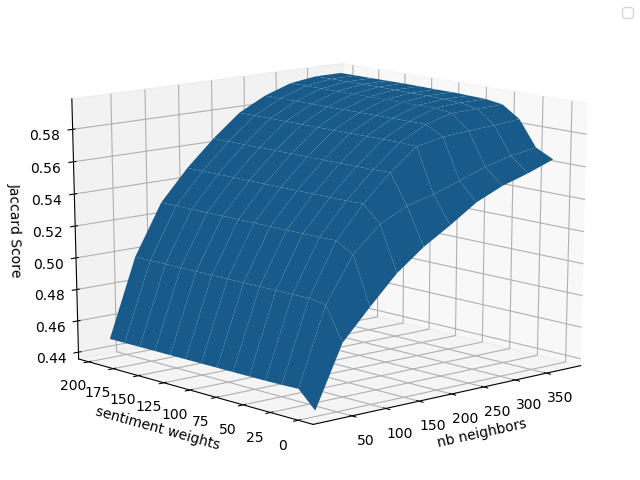

No handles with labels found to put in legend.


In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT)
print("The optimal sentiment weight is :", SENTIMENT_WEIGHT_OPT)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX)

# Create the grid and the axes
LIST_NEIGHBORS = np.arange(NB_NEIGHBORS_MIN, NB_NEIGHBORS_MAX, STEP_NEIGH)
LIST_WEIGHTS = np.arange(SENTIMENT_WEIGHT_MIN, SENTIMENT_WEIGHT_MAX, STEP_WEIGHT)
(NEIGHBORS, WEIGHTS) = np.meshgrid(LIST_NEIGHBORS, LIST_WEIGHTS)
ax = Axes3D(plt.figure())

# Show the plots
ax.plot_surface(NEIGHBORS, WEIGHTS, np.reshape(JACCARD_LIST, (len(LIST_NEIGHBORS), -1)).T)
ax.set_xlabel('nb neighbors')
ax.set_ylabel('sentiment weights')
ax.set_zlabel('Jaccard Score')
plt.legend()
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_sentiment_{}.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX, SENTIMENT_WEIGHT_MAX))
plt.show()

#### Only neutral sentiments

In [18]:
# --- Optimize the number of neighbors and the weight sentiment --- #
# --- Only neutral sentiments --- #
# Parameter
NB_NEIGHBORS_MAX_NEUTRAL = 300
NB_NEIGHBORS_MIN_NEUTRAL = 5
STEP_NEIGH_NEUTRAL = 15

# Variables
NB_NEIGHBORS_OPT_NEUTRAL = 1
SENTIMENT_WEIGHT_OPT_NEUTRAL = 1
JACCARD_ACC_MAX_NEUTRAL = 0
JACCARD_LIST_NEUTRAL = []

# Select the neutral sentiments
TRAIN_SELECTION_NEUTRAL = np.where(TWEET_SCALARS_TRAIN[:, -1] == 0)
VALID_SELECTION_NEUTRAL = np.where(TWEET_SCALARS_VALID[:, -1] == 0)

TWEET_SCALARS_TRAIN_NEUTRAL = TWEET_SCALARS_TRAIN[TRAIN_SELECTION_NEUTRAL]
IMPORTANT_WORDS_TRAIN_NEUTRAL = IMPORTANT_WORDS_TRAIN[TRAIN_SELECTION_NEUTRAL]

TWEET_SCALARS_VALID_NEUTRAL = TWEET_SCALARS_VALID[VALID_SELECTION_NEUTRAL]
TWEET_ORIGINALS_VALID_NEUTRAL = TWEET_ORIGINALS_VALID[VALID_SELECTION_NEUTRAL]
TWEET_STRINGS_VALID_NEUTRAL = np.array(TWEET_STRINGS_VALID, dtype=object)[VALID_SELECTION_NEUTRAL]
LABEL_ORIGINALS_VALID_NEUTRAL = LABEL_ORIGINALS_VALID[VALID_SELECTION_NEUTRAL]


for nb_neigh in range(NB_NEIGHBORS_MIN_NEUTRAL, NB_NEIGHBORS_MAX_NEUTRAL, STEP_NEIGH_NEUTRAL):
    # Define the knn
    KNN = KNeighborsRegressor(nb_neigh, weights="distance")

    # Train the knn
    KNN.fit(TWEET_SCALARS_TRAIN_NEUTRAL, IMPORTANT_WORDS_TRAIN_NEUTRAL)

    # Scalar predictions
    PRED_SCALAR_NEUTRAL = KNN.predict(TWEET_SCALARS_VALID_NEUTRAL)

    # Get the string predictions
    PRED_STRING_NEUTRAL = preds_to_strings(TWEET_ORIGINALS_VALID_NEUTRAL, TWEET_STRINGS_VALID_NEUTRAL, PRED_SCALAR_NEUTRAL)

    # Compute the loss
    JACCARD_ACC_NEUTRAL = mean_jaccard(LABEL_ORIGINALS_VALID_NEUTRAL, PRED_STRING_NEUTRAL)

    # Print results
    print("Jaccard score", JACCARD_ACC_NEUTRAL)
    print("Number neighbors", nb_neigh)
    print("\n")

    # Updates
    JACCARD_LIST_NEUTRAL.append(JACCARD_ACC_NEUTRAL)
    if JACCARD_ACC_NEUTRAL > JACCARD_ACC_MAX_NEUTRAL:
        JACCARD_ACC_MAX_NEUTRAL = JACCARD_ACC_NEUTRAL
        NB_NEIGHBORS_OPT_NEUTRAL = nb_neigh

Jaccard score 0.5637874102458298
Number neighbors 5


Jaccard score 0.6824693670522808
Number neighbors 20


Jaccard score 0.7296051739829417
Number neighbors 35


Jaccard score 0.7594450875340851
Number neighbors 50


Jaccard score 0.7843290631395844
Number neighbors 65


Jaccard score 0.8070461085236228
Number neighbors 80


Jaccard score 0.8286509925863615
Number neighbors 95


Jaccard score 0.8499298555547098
Number neighbors 110


Jaccard score 0.8650151043076392
Number neighbors 125


Jaccard score 0.8778525270479748
Number neighbors 140


Jaccard score 0.891861615802454
Number neighbors 155


Jaccard score 0.9024302859916621
Number neighbors 170


Jaccard score 0.9115510696217012
Number neighbors 185


Jaccard score 0.923605532054228
Number neighbors 200


Jaccard score 0.9379998015873262
Number neighbors 215


Jaccard score 0.9451054808388708
Number neighbors 230


Jaccard score 0.9539380485102507
Number neighbors 245


Jaccard score 0.9582544964734567
Number neighbors 260


Ja

No handles with labels found to put in legend.


The optimal number of neighbors to take is : 290
With this parameters, the Jaccard accuracy is : 0.9654367695576584


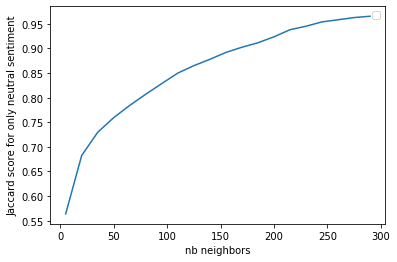

In [20]:
import matplotlib.pyplot as plt

# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT_NEUTRAL)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX_NEUTRAL)

# Show the plots
LIST_NEIGHBORS_NEUTRAL = np.arange(NB_NEIGHBORS_MIN_NEUTRAL, NB_NEIGHBORS_MAX_NEUTRAL, STEP_NEIGH_NEUTRAL)
plt.plot(LIST_NEIGHBORS_NEUTRAL, JACCARD_LIST_NEUTRAL)
plt.xlabel('nb neighbors')
plt.ylabel('Jaccard score for only neutral sentiment')
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_only_neutral.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX_NEUTRAL))
plt.show()

#### Only positive sentiments

In [23]:
# --- Optimize the number of neighbors and the weight sentiment --- #
# --- Only positive sentiments --- #
# Parameter
NB_NEIGHBORS_MAX_POSITIVE = 300
NB_NEIGHBORS_MIN_POSITIVE = 5
STEP_NEIGH_POSITIVE = 15

# Variables
NB_NEIGHBORS_OPT_POSITIVE = 1
SENTIMENT_WEIGHT_OPT_POSITIVE = 1
JACCARD_ACC_MAX_POSITIVE = 0
JACCARD_LIST_POSITIVE = []

# Select the positive sentiments
TRAIN_SELECTION_POSITIVE = np.where(TWEET_SCALARS_TRAIN[:, -1] == 1)
VALID_SELECTION_POSITIVE = np.where(TWEET_SCALARS_VALID[:, -1] == 1)

TWEET_SCALARS_TRAIN_POSITIVE = TWEET_SCALARS_TRAIN[TRAIN_SELECTION_POSITIVE]
IMPORTANT_WORDS_TRAIN_POSITIVE = IMPORTANT_WORDS_TRAIN[TRAIN_SELECTION_POSITIVE]

TWEET_SCALARS_VALID_POSITIVE = TWEET_SCALARS_VALID[VALID_SELECTION_POSITIVE]
TWEET_ORIGINALS_VALID_POSITIVE = TWEET_ORIGINALS_VALID[VALID_SELECTION_POSITIVE]
TWEET_STRINGS_VALID_POSITIVE = np.array(TWEET_STRINGS_VALID, dtype=object)[VALID_SELECTION_POSITIVE]
LABEL_ORIGINALS_VALID_POSITIVE = LABEL_ORIGINALS_VALID[VALID_SELECTION_POSITIVE]


for nb_neigh in range(NB_NEIGHBORS_MIN_POSITIVE, NB_NEIGHBORS_MAX_POSITIVE, STEP_NEIGH_POSITIVE):
    # Define the knn
    KNN = KNeighborsRegressor(nb_neigh, weights="distance")

    # Train the knn
    KNN.fit(TWEET_SCALARS_TRAIN_POSITIVE, IMPORTANT_WORDS_TRAIN_POSITIVE)

    # Scalar predictions
    PRED_SCALAR_POSITIVE = KNN.predict(TWEET_SCALARS_VALID_POSITIVE)

    # Get the string predictions
    PRED_STRING_POSITIVE = preds_to_strings(TWEET_ORIGINALS_VALID_POSITIVE, TWEET_STRINGS_VALID_POSITIVE, PRED_SCALAR_POSITIVE)

    # Compute the loss
    JACCARD_ACC_POSITIVE = mean_jaccard(LABEL_ORIGINALS_VALID_POSITIVE, PRED_STRING_POSITIVE)

    # Print results
    print("Jaccard score", JACCARD_ACC_POSITIVE)
    print("Number neighbors", nb_neigh)
    print("\n")

    # Updates
    JACCARD_LIST_POSITIVE.append(JACCARD_ACC_POSITIVE)
    if JACCARD_ACC_POSITIVE > JACCARD_ACC_MAX_POSITIVE:
        JACCARD_ACC_MAX_POSITIVE = JACCARD_ACC_POSITIVE
        NB_NEIGHBORS_OPT_POSITIVE = nb_neigh

Jaccard score 0.2660899568697556
Number neighbors 5


Jaccard score 0.27849482922889707
Number neighbors 20


Jaccard score 0.29303518840798654
Number neighbors 35


Jaccard score 0.3028182778832773
Number neighbors 50


Jaccard score 0.3090076747382816
Number neighbors 65


Jaccard score 0.3152825555005277
Number neighbors 80


Jaccard score 0.31628252491596265
Number neighbors 95


Jaccard score 0.31837941485420024
Number neighbors 110


Jaccard score 0.3221590313444847
Number neighbors 125


Jaccard score 0.3210620627676563
Number neighbors 140


Jaccard score 0.326086325116789
Number neighbors 155


Jaccard score 0.32772965770689316
Number neighbors 170


Jaccard score 0.32832119124058434
Number neighbors 185


Jaccard score 0.3283802111839401
Number neighbors 200


Jaccard score 0.3286390394146877
Number neighbors 215


Jaccard score 0.328522841346439
Number neighbors 230


Jaccard score 0.32931666100161217
Number neighbors 245


Jaccard score 0.3288167894397493
Number neighbors 2

(314, 2501)
The optimal number of neighbors to take is : 290
With this parameters, the Jaccard accuracy is : 0.3304103271073822


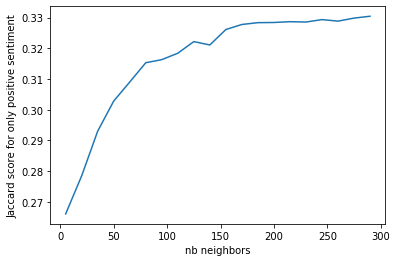

In [30]:
import matplotlib.pyplot as plt
# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT_POSITIVE)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX_POSITIVE)

# Show the plots
LIST_NEIGHBORS_POSITIVE = np.arange(NB_NEIGHBORS_MIN_POSITIVE, NB_NEIGHBORS_MAX_POSITIVE, STEP_NEIGH_POSITIVE)
plt.plot(LIST_NEIGHBORS_POSITIVE, JACCARD_LIST_POSITIVE)
plt.xlabel('nb neighbors')
plt.ylabel('Jaccard score for only positive sentiment')
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_only_positive.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX_POSITIVE))
plt.show()

#### Only negative sentiments

In [31]:
# --- Optimize the number of neighbors and the weight sentiment --- #
# --- Only negative sentiments --- #
# Parameter
NB_NEIGHBORS_MAX_NEGATIVE = 300
NB_NEIGHBORS_MIN_NEGATIVE = 5
STEP_NEIGH_NEGATIVE = 15

# Variables
NB_NEIGHBORS_OPT_NEGATIVE = 1
SENTIMENT_WEIGHT_OPT_NEGATIVE = 1
JACCARD_ACC_MAX_NEGATIVE = 0
JACCARD_LIST_NEGATIVE = []

# Select the negative sentiments
TRAIN_SELECTION_NEGATIVE = np.where(TWEET_SCALARS_TRAIN[:, -1] == -1)
VALID_SELECTION_NEGATIVE = np.where(TWEET_SCALARS_VALID[:, -1] == -1)

TWEET_SCALARS_TRAIN_NEGATIVE = TWEET_SCALARS_TRAIN[TRAIN_SELECTION_NEGATIVE]
IMPORTANT_WORDS_TRAIN_NEGATIVE = IMPORTANT_WORDS_TRAIN[TRAIN_SELECTION_NEGATIVE]

TWEET_SCALARS_VALID_NEGATIVE = TWEET_SCALARS_VALID[VALID_SELECTION_NEGATIVE]
TWEET_ORIGINALS_VALID_NEGATIVE = TWEET_ORIGINALS_VALID[VALID_SELECTION_NEGATIVE]
TWEET_STRINGS_VALID_NEGATIVE = np.array(TWEET_STRINGS_VALID, dtype=object)[VALID_SELECTION_NEGATIVE]
LABEL_ORIGINALS_VALID_NEGATIVE = LABEL_ORIGINALS_VALID[VALID_SELECTION_NEGATIVE]


for nb_neigh in range(NB_NEIGHBORS_MIN_NEGATIVE, NB_NEIGHBORS_MAX_NEGATIVE, STEP_NEIGH_NEGATIVE):
    # Define the knn
    KNN = KNeighborsRegressor(nb_neigh, weights="distance")

    # Train the knn
    KNN.fit(TWEET_SCALARS_TRAIN_NEGATIVE, IMPORTANT_WORDS_TRAIN_NEGATIVE)

    # Scalar predictions
    PRED_SCALAR_NEGATIVE = KNN.predict(TWEET_SCALARS_VALID_NEGATIVE)

    # Get the string predictions
    PRED_STRING_NEGATIVE = preds_to_strings(TWEET_ORIGINALS_VALID_NEGATIVE, TWEET_STRINGS_VALID_NEGATIVE, PRED_SCALAR_NEGATIVE)

    # Compute the loss
    JACCARD_ACC_NEGATIVE = mean_jaccard(LABEL_ORIGINALS_VALID_NEGATIVE, PRED_STRING_NEGATIVE)

    # Print results
    print("Jaccard score", JACCARD_ACC_NEGATIVE)
    print("Number neighbors", nb_neigh)
    print("\n")

    # Updates
    JACCARD_LIST_NEGATIVE.append(JACCARD_ACC_NEGATIVE)
    if JACCARD_ACC_NEGATIVE > JACCARD_ACC_MAX_NEGATIVE:
        JACCARD_ACC_MAX_NEGATIVE = JACCARD_ACC_NEGATIVE
        NB_NEIGHBORS_OPT_NEGATIVE = nb_neigh

Jaccard score 0.2700144863916125
Number neighbors 5


Jaccard score 0.2915496389422504
Number neighbors 20


Jaccard score 0.2920705411539416
Number neighbors 35


Jaccard score 0.29500949194797454
Number neighbors 50


Jaccard score 0.3061672159785238
Number neighbors 65


Jaccard score 0.3102275029198084
Number neighbors 80


Jaccard score 0.31388186780907507
Number neighbors 95


Jaccard score 0.3144744684839807
Number neighbors 110


Jaccard score 0.31380595666614264
Number neighbors 125


Jaccard score 0.31540761468354817
Number neighbors 140


Jaccard score 0.31861178867123324
Number neighbors 155


Jaccard score 0.3204769286990374
Number neighbors 170


Jaccard score 0.32049054020986356
Number neighbors 185


Jaccard score 0.3215674142477817
Number neighbors 200


Jaccard score 0.32237311943701474
Number neighbors 215


Jaccard score 0.3235782964923278
Number neighbors 230


Jaccard score 0.32512496682874775
Number neighbors 245


Jaccard score 0.3263646690704402
Number neighbor

The optimal number of neighbors to take is : 290
With this parameters, the Jaccard accuracy is : 0.3272137681250705


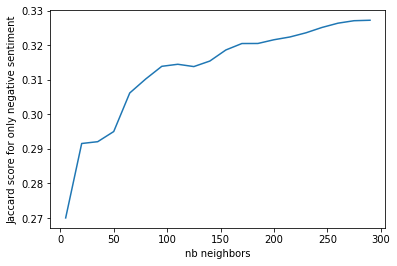

In [32]:
import matplotlib.pyplot as plt
# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT_NEGATIVE)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX_NEGATIVE)

# Show the plots
LIST_NEIGHBORS_NEGATIVE = np.arange(NB_NEIGHBORS_MIN_NEGATIVE, NB_NEIGHBORS_MAX_NEGATIVE, STEP_NEIGH_NEGATIVE)
plt.plot(LIST_NEIGHBORS_NEGATIVE, JACCARD_LIST_NEGATIVE)
plt.xlabel('nb neighbors')
plt.ylabel('Jaccard score for only negative sentiment')
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_only_negative.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX_NEGATIVE))
plt.show()

#### Positive and negative sentiment in the same classifier

In [52]:
# --- Optimize the number of neighbors and the weight sentiment --- #
# --- Positive and negative sentiments --- #
# Parameter
NB_NEIGHBORS_MAX_POS_NEG = 400
NB_NEIGHBORS_MIN_POS_NEG = 20
STEP_NEIGH_POS_NEG = 40
SENTIMENT_WEIGHT_MAX_POS_NEG = 200
SENTIMENT_WEIGHT_MIN_POS_NEG = 1
STEP_WEIGHT_POS_NEG = 10

# Variables
NB_NEIGHBORS_OPT_POS_NEG = 1
SENTIMENT_WEIGHT_OPT_POS_NEG = 1
JACCARD_ACC_MAX_POS_NEG = 0
JACCARD_LIST_POS_NEG = []

# Select the negative sentiments
TRAIN_SELECTION_POS = np.where(TWEET_SCALARS_TRAIN[:, -1] == 1)[0]
TRAIN_SELECTION_NEG = np.where(TWEET_SCALARS_TRAIN[:, -1] == -1)[0]
TRAIN_SELECTION_POS_NEG = np.concatenate((TRAIN_SELECTION_POS, TRAIN_SELECTION_NEG))
                                         
VALID_SELECTION_POS = np.where(TWEET_SCALARS_VALID[:, -1] == 1)[0]
VALID_SELECTION_NEG = np.where(TWEET_SCALARS_VALID[:, -1] == -1)[0]
VALID_SELECTION_POS_NEG = np.concatenate((VALID_SELECTION_POS, VALID_SELECTION_NEG))


TWEET_SCALARS_TRAIN_POS_NEG = TWEET_SCALARS_TRAIN[TRAIN_SELECTION_POS_NEG]
IMPORTANT_WORDS_TRAIN_POS_NEG = IMPORTANT_WORDS_TRAIN[TRAIN_SELECTION_POS_NEG]

TWEET_SCALARS_VALID_POS_NEG = TWEET_SCALARS_VALID[VALID_SELECTION_POS_NEG]
TWEET_ORIGINALS_VALID_POS_NEG = TWEET_ORIGINALS_VALID[VALID_SELECTION_POS_NEG]
TWEET_STRINGS_VALID_POS_NEG = np.array(TWEET_STRINGS_VALID, dtype=object)[VALID_SELECTION_POS_NEG]
LABEL_ORIGINALS_VALID_POS_NEG = LABEL_ORIGINALS_VALID[VALID_SELECTION_POS_NEG]

for nb_neigh in range(NB_NEIGHBORS_MIN_POS_NEG, NB_NEIGHBORS_MAX_POS_NEG, STEP_NEIGH_POS_NEG):
    for sentiment_weight in range(SENTIMENT_WEIGHT_MIN_POS_NEG, SENTIMENT_WEIGHT_MAX_POS_NEG, STEP_WEIGHT_POS_NEG):
        # Modify the sentiments
        SCALARS_TRAIN_POS_NEG = TWEET_SCALARS_TRAIN_POS_NEG.copy()
        SCALARS_TRAIN_POS_NEG[:, -1] *= sentiment_weight
        SCALARS_VALID_POS_NEG = TWEET_SCALARS_VALID_POS_NEG.copy()
        SCALARS_VALID_POS_NEG[:, -1] *= sentiment_weight
        
        # Define the knn
        KNN = KNeighborsRegressor(nb_neigh, weights="distance")

        # Train the knn
        KNN.fit(SCALARS_TRAIN_POS_NEG, IMPORTANT_WORDS_TRAIN_POS_NEG)

        # Scalar predictions
        PRED_SCALAR_POS_NEG = KNN.predict(SCALARS_VALID_POS_NEG)

        # Get the string predictions
        PRED_STRING_POS_NEG = preds_to_strings(TWEET_ORIGINALS_VALID_POS_NEG, TWEET_STRINGS_VALID_POS_NEG, PRED_SCALAR_POS_NEG)

        # Compute the loss
        JACCARD_ACC_POS_NEG = mean_jaccard(LABEL_ORIGINALS_VALID_POS_NEG, PRED_STRING_POS_NEG)

        # Print results
        print("Jaccard score", JACCARD_ACC_POS_NEG)
        print("Sentiment weight", sentiment_weight)
        print("Number neighbors", nb_neigh)
        print("\n")
        
        # Updates
        JACCARD_LIST_POS_NEG.append(JACCARD_ACC_POS_NEG)
        if JACCARD_ACC_POS_NEG > JACCARD_ACC_MAX_POS_NEG:
            JACCARD_ACC_MAX_POS_NEG = JACCARD_ACC_POS_NEG
            NB_NEIGHBORS_OPT_POS_NEG = nb_neigh    
            SENTIMENT_WEIGHT_OPT_POS_NEG = sentiment_weight

Jaccard score 0.28492374067388243
Sentiment weight 1
Number neighbors 20


Jaccard score 0.2850026722702373
Sentiment weight 11
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 21
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 31
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 41
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 51
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 61
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 71
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 81
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 91
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 101
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 111
Number neighbors 20


Jaccard score 0.28502223408557376
Sentiment weight 121
Number neighbors 20


Jaccard sco

Jaccard score 0.3253983928948065
Sentiment weight 71
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 81
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 91
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 101
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 111
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 121
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 131
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 141
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 151
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 161
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 171
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 181
Number neighbors 220


Jaccard score 0.3253983928948065
Sentiment weight 191
Number neighbors 220


Ja

The optimal number of neighbors to take is : 340
The optimal sentiment weight is : 61
With this parameters, the Jaccard accuracy is : 0.3298793328660828


<IPython.core.display.Javascript object>


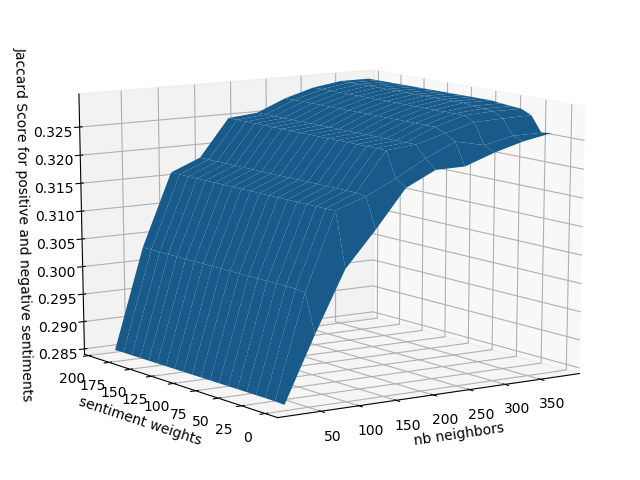

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT_POS_NEG)
print("The optimal sentiment weight is :", SENTIMENT_WEIGHT_OPT_POS_NEG)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX_POS_NEG)

# Create the grid and the axes
LIST_NEIGHBORS_POS_NEG = np.arange(NB_NEIGHBORS_MIN_POS_NEG, NB_NEIGHBORS_MAX_POS_NEG, STEP_NEIGH_POS_NEG)
LIST_WEIGHTS_POS_NEG = np.arange(SENTIMENT_WEIGHT_MIN_POS_NEG, SENTIMENT_WEIGHT_MAX_POS_NEG, STEP_WEIGHT_POS_NEG)
(NEIGHBORS_POS_NEG, WEIGHTS_POS_NEG) = np.meshgrid(LIST_NEIGHBORS_POS_NEG, LIST_WEIGHTS_POS_NEG)
ax = Axes3D(plt.figure())

# Show the plots
ax.plot_surface(NEIGHBORS_POS_NEG, WEIGHTS_POS_NEG, np.reshape(JACCARD_LIST_POS_NEG, (len(LIST_NEIGHBORS_POS_NEG), -1)).T)
ax.set_xlabel('nb neighbors')
ax.set_ylabel('sentiment weights')
ax.set_zlabel('Jaccard Score for positive and negative sentiments')
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_sentiment_{}_positive_negative.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX_POS_NEG, SENTIMENT_WEIGHT_MAX_POS_NEG))
plt.show()

In [ ]:
PRED_SCALAR = KNN.predict(TWEET_SCALARS_VALID)
print("Nomber of correct match", np.sum(PREDICTIONS == IMPORTANT_WORDS_VALID))
print("Number of match to make", len(PREDICTIONS) * len(PREDICTIONS[0]))

In [ ]:
PRED_STRING = preds_to_strings(TWEET_ORIGINALS_VALID, TWEET_STRINGS_VALID, PRED_SCALAR)

In [ ]:
SHOW_RESULT = False
if SHOW_RESULT:
    for idx_tweet in range(len(RESULTS)):
        print(TWEET_ORIGINALS_VALID[idx_tweet])
        print(IMPORTANT_WORDS_VALID[idx_tweet])
        print(PRED_SCALAR[idx_tweet])
        print(PRED_STRING[idx_tweet], "\n")

In [ ]:
from utils.loss import mean_jaccard

JACCARD_ACC = mean_jaccard(LABEL_ORIGINALS_VALID, PRED_STRING)
print(JACCARD_ACC)